### Import Packages

Here is where we import all the packages we need. Noteably, NumPy is a standard computing package, Pandas is for data manipulation, and Torch is the Python machine learning package.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch as torch
import torch.nn as nn
import os
from math import *
import copy
from scipy.integrate import odeint
from matplotlib.lines import Line2D
from tabulate import tabulate
import matplotlib.cm as cm
import matplotlib
import random
from mpl_toolkits.mplot3d import Axes3D
from math import *
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from torch.utils.data import DataLoader, Dataset
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu") 
#this line says that if we have a GPU, it will do the computations there.
print(device)

cpu


### Formatting .csv data files

In [3]:
#upload .csv file and skip 13 header rows
DTS_calib = pd.read_csv('00 to 23 15May2020 BinaryTemp copy.csv', skiprows=range(13)).head(100).iloc[:, 1:]

#check to see the rows and columns have been skipped
print(DTS_calib.head())

#create new file which stores the updated version (without headers or depth)
DTS_calib.to_csv('00 to 23 15May2020 BinaryTemp no header top 100.csv', index=False)


     20.36    21.02    20.75    20.76    20.85    21.01  20.7299    20.87  \
0  20.5699  21.2199  20.9599  20.8700  21.0400  21.2000  20.9400  21.0200   
1  26.4699  27.0499  26.7700  26.4599  26.8999  26.6900  26.7900  26.6399   
2  19.9500  20.5799  20.3700  20.1299  20.5499  20.4699  20.4300  20.3199   
3  20.2500  20.7600  20.6399  20.4500  20.7399  20.7999  20.7399  20.6100   
4  20.6800  21.0400  20.9500  20.9599  20.9799  21.3199  21.1700  21.0400   

   20.9599  20.8099  ...    19.85    20.43  19.6399  19.4699    20.12  \
0  21.4699  20.9099  ...  20.0300  20.8400  19.7800  19.6200  20.3999   
1  27.0100  25.9899  ...  25.6700  26.6000  25.5499  25.4699  26.1299   
2  20.5100  20.4500  ...  19.3899  20.1000  19.1800  19.2299  19.8299   
3  20.7600  20.7099  ...  19.6100  20.2099  19.4099  19.2900  19.8099   
4  21.0599  21.0300  ...  19.8799  20.2900  19.7199  19.2900  19.7099   

     19.37  19.6399.1    19.77    20.34  20.1599  
0  19.5900    19.7000  20.0000  20.6700  20.260

In [4]:
#convert the DataFrame which we created using Pandas from .csv file into a NumPy array
observed_temp = DTS_calib.to_numpy()

#Define the dimensions of the array
num_depths, num_hours = observed_temp.shape

#define a time vector (to be used in later versions to compute splines, this is currently arbitrary)
t = np.linspace(0, 23, num = 24)
print(t)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23.]


### Spline approximation

In [5]:
#initialize arrays to store the spline-smoothed data and derivatives
smoothed_observed_temp = np.zeros(observed_temp.shape)
spline_deriv=np.zeros(observed_temp.shape)

# Loop through each row (depth) and fit a spline to smooth the temperature data
for i in range(observed_temp.shape[0]):
    #shape[0] accesses the first dimension of the array, ie, tells us how many rows
        #the code knows to do rows (depths) because of the shape[0] command
    # Fit a spline to the data for each row (depth)
    spline = UnivariateSpline(t, observed_temp[i, :], s=0.08)

    # Evaluate the spline at each hour to get the smoothed temperature data
    smoothed_observed_temp[i, :] = spline(t)

    # Calculate the spline derivative at each hour for the given row (depth)
    spline_deriv[i, :] = spline.derivative()(t)

/var/folders/q3/37ybk4wx2qzc09d76v2wnxp80000gn/T/ipykernel_55588/1643385382.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name)


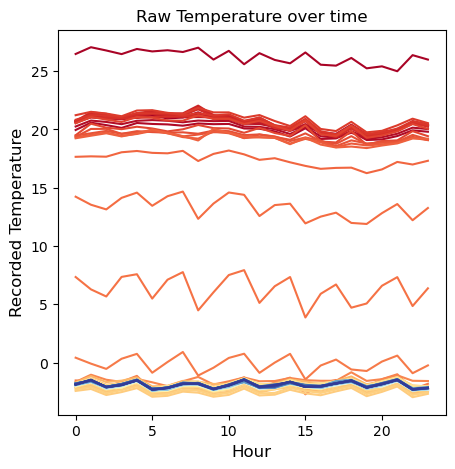

In [6]:
fig = plt.figure(figsize = (5,5))
y_low = np.min(observed_temp)
y_top = np.max(observed_temp)
plt.title('Raw Temperature over time', fontsize = 12)
plt.xlabel('Hour', fontsize = 12)
plt.ylabel('Recorded Temperature', fontsize = 12)
# plt.xlim(0, 2)

# Define the colormap. RdYlBu goes from red to blue (0ft=red, 100ft=blue)
cmap_name = 'RdYlBu'
cmap = cm.get_cmap(cmap_name)
#the error message is not a true error but a warning that the cmap command is soon to be outdated

# Calculate the color index (value between 0 and 1) based on the index 'i'
for i in range(len(observed_temp)):
    color_index = i / len(observed_temp)  # Maps i to a value between 0 and 1

    # Get the color from the colormap
    color = cmap(color_index)

    # Plot the data with the chosen color
    plt.plot(t, observed_temp[i, :], color=color)

/var/folders/q3/37ybk4wx2qzc09d76v2wnxp80000gn/T/ipykernel_55588/3264495511.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name)


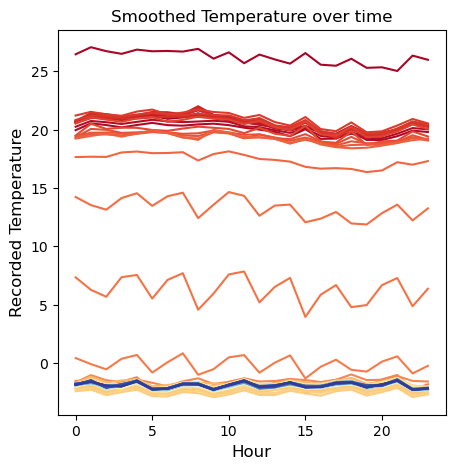

In [7]:
fig = plt.figure(figsize = (5,5))
y_low = np.min(smoothed_observed_temp)
y_top = np.max(smoothed_observed_temp)
plt.title('Smoothed Temperature over time', fontsize = 12)
plt.xlabel('Hour', fontsize = 12)
plt.ylabel('Recorded Temperature', fontsize = 12)
# plt.xlim(0, 2)

# Define the colormap. RdYlBu goes from red to blue (0ft=red, 100ft=blue)
cmap_name = 'RdYlBu'
cmap = cm.get_cmap(cmap_name)
#the error message is not a true error but a warning that the cmap command is soon to be outdated

# Calculate the color index (value between 0 and 1) based on the index 'i'
for i in range(len(observed_temp)):
    color_index = i / len(observed_temp)  # Maps i to a value between 0 and 1

    # Get the color from the colormap
    color = cmap(color_index)

    # Plot the data with the chosen color
    plt.plot(t, smoothed_observed_temp[i, :], color=color)

/var/folders/q3/37ybk4wx2qzc09d76v2wnxp80000gn/T/ipykernel_53352/3344968705.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name)


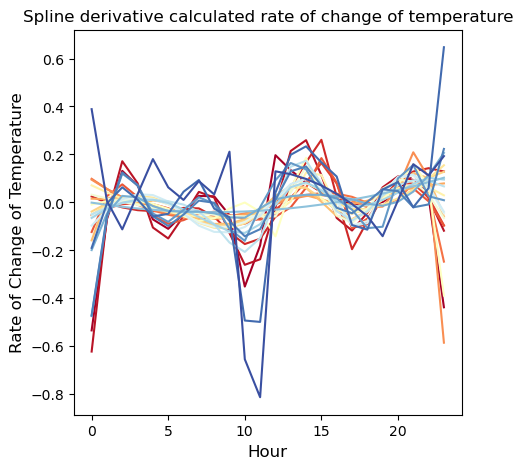

In [7]:
fig = plt.figure(figsize = (5,5))
y_low = np.min(spline_deriv)
y_top = np.max(spline_deriv)
plt.title('Spline derivative calculated rate of change of temperature', fontsize = 12)
plt.xlabel('Hour', fontsize = 12)
plt.ylabel('Rate of Change of Temperature', fontsize = 12)
# plt.xlim(0, 2)

# Define the colormap. RdYlBu goes from red to blue (0ft=red, 100ft=blue)
cmap_name = 'RdYlBu'
cmap = cm.get_cmap(cmap_name)
#the error message is not a true error but a warning that the cmap command is soon to be outdated

# Calculate the color index (value between 0 and 1) based on the index 'i'
for i in range(len(t)):
    color_index = i / len(t)  # Maps i to a value between 0 and 1

    # Get the color from the colormap
    color = cmap(color_index)

    # Plot the data with the chosen color
    plt.plot(t, spline_deriv[i, :], color=color)
    

### Difference quotients to get derivative approximation

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[[-0.27981015  0.05272412  0.12292976 ...  0.07957745  0.1018994
  -0.1760312 ]
 [-0.31483118  0.08191411  0.15308918 ...  0.10629303  0.06108875
  -0.04475161]
 [ 0.01107166 -0.01170817 -0.02708155 ...  0.11057456  0.13815104
   0.13818584]
 ...
 [ 0.07013962  0.02320785  0.03510411 ...  0.00053649  0.01672686
   0.03811482]
 [ 0.06260708  0.03455807  0.04193977 ... -0.0048157   0.00271191
   0.01316791]
 [ 0.06027059  0.03243285  0.05230167 ...  0.00321359  0.01505309
   0.03066906]]


/var/folders/q3/37ybk4wx2qzc09d76v2wnxp80000gn/T/ipykernel_53352/2766453127.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name)


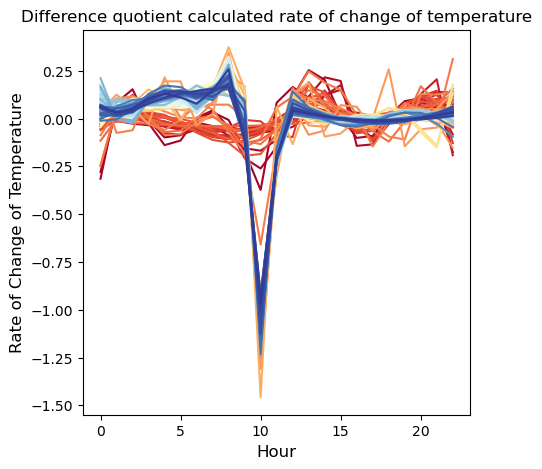

In [8]:
#define the time step size (delta_t)
delta_t=[]
for i in range(len(t) -1):
    diff = t[i+1] - t[i]
    delta_t.append(diff)

print(delta_t)

#initialize array to store the difference quotients 
diff_quots=np.zeros((num_depths, num_hours-1))
    
#compute difference quotient for each row (because we want the difference quotient hour to hour)
#using smothed_observed_data because the purpose of the spline approximation is to get better difference quotients
for i in range(num_depths):
    for j in range(num_hours - 1):
        diff_quots[i,j] = (smoothed_observed_temp[i, j+1] - smoothed_observed_temp[i,j])/delta_t[j]
        
print(diff_quots)



fig = plt.figure(figsize = (5,5))
y_low = np.min(diff_quots)
y_top = np.max(diff_quots)
plt.title('Difference quotient calculated rate of change of temperature', fontsize = 12)
plt.xlabel('Hour', fontsize = 12)
plt.ylabel('Rate of Change of Temperature', fontsize = 12)
# plt.xlim(0, 2)

# Define the colormap. RdYlBu goes from red to blue (0ft=red, 100ft=blue)
cmap_name = 'RdYlBu'
cmap = cm.get_cmap(cmap_name)
#the error message is not a true error but a warning that the cmap command is soon to be outdated


# Calculate the color index (value between 0 and 1) based on the index 'i'
for i in range(num_depths):
    color_index = i / num_depths  # Maps i to a value between 0 and 1
    
    # Get the color from the colormap
    color = cmap(color_index)

    # Plot the data with the chosen color
    plt.plot(t[:-1], diff_quots[i, :], color=color)

### Setup the model

In [9]:
from torch.autograd import Variable
from torch.autograd import Function # import Function to create custom activations
from torch.nn.parameter import Parameter # import Parameter to create custom activations with learnable parameters

In [10]:
#this block is neural network specific things we want to load in order to build and train the model

class LoadDataset(Dataset):
    def __init__(self, inputs, targets):
        self.x = inputs
        self.y = targets

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        inputs = self.x[idx, :]
        targets = self.y[idx, :]

        return inputs, targets

In [11]:
#here we define a few hyperparameters
epochs = 200
batch_size = 100
input_size = 1 #we give the net as input the temperature at a fixed time and depth
hidden_size1 = 10
hidden_size2 = 20
output_size = 1 #the net outputs the T' for the given T. This gives one equation for all depths

#to have one equation per depth, the network should have input 100
# and output 100 where 100 = number of depths at a fixed time (this is for a later version)

class Net(nn.Module) :

    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(Net, self).__init__()
        self.linear1 = torch.nn.Linear(input_size,   hidden_size1, bias=True)
        self.linear2 = torch.nn.Linear(hidden_size1, hidden_size2, bias=True)
        self.linear3 = torch.nn.Linear(hidden_size2, hidden_size2, bias=True)
        self.linear4 = torch.nn.Linear(hidden_size2, hidden_size2, bias=True)
        self.linear5 = torch.nn.Linear(hidden_size2, hidden_size2, bias=True)
        self.linear6 = torch.nn.Linear(hidden_size2, hidden_size2, bias=True)
        self.linear7 = torch.nn.Linear(hidden_size2, hidden_size2, bias=True)
        self.linear8 = torch.nn.Linear(hidden_size2, output_size,  bias=True)

        self.mylrelu = torch.nn.LeakyReLU()    #Two_corners_LReLU()
        
    def forward(self, x):
        x = self.mylrelu(self.linear1(x))
        x = self.mylrelu(self.linear2(x))
        x = self.mylrelu(self.linear3(x))
        x = self.mylrelu(self.linear4(x))
        x = self.mylrelu(self.linear5(x))
        x = self.mylrelu(self.linear6(x))
        x = self.mylrelu(self.linear7(x))
        x = self.linear8(x)
        return x
        
#name our network net
net = Net(input_size, hidden_size1, hidden_size2, output_size).to(device)
print(net)

Net(
  (linear1): Linear(in_features=1, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=20, bias=True)
  (linear3): Linear(in_features=20, out_features=20, bias=True)
  (linear4): Linear(in_features=20, out_features=20, bias=True)
  (linear5): Linear(in_features=20, out_features=20, bias=True)
  (linear6): Linear(in_features=20, out_features=20, bias=True)
  (linear7): Linear(in_features=20, out_features=20, bias=True)
  (linear8): Linear(in_features=20, out_features=1, bias=True)
  (mylrelu): LeakyReLU(negative_slope=0.01)
)


### Training the Network

In [12]:
#define our inputs and targets for the training data
observed_temp_short = observed_temp[:,1:]
print(observed_temp_short.shape)
train_data = torch.from_numpy(observed_temp_short.reshape(-1,1))
print('train data',train_data.shape)
train_expected = torch.from_numpy(diff_quots.reshape(-1,1))
print('expected shape', train_expected.shape)

#define dataset to use when training
dataset = LoadDataset(train_data, train_expected)
print(len(dataset))

# This loads data in batches which you can now change to be more than 1 without errors
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# print(len(dataloader))
#we use Adam as the optimizer, an automatic stochastic gradient descent algorithm
#we can tune the hyperparameters if desired
optimizer = torch.optim.Adam(net.parameters(), lr=1e-04, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

#define the loss function, in our case, mean squared error
loss = torch.nn.MSELoss()

#initialize an empty list of losses, loss starts at 0.

l2_loss_list = []
net.train()
for epoch in range(epochs): 
    # if epoch % 10 == 0:
    #     for param_group in optimizer.param_groups:
    #         param_group['lr'] /= 2.

    train_loss = 0
    batch_idx = 0
    for input_data, target_data in dataloader:
        # print('input shape',input_data.shape)
        input_data = input_data.to(device).float() #or use batch size instead of -1 but add , drop_last=True in DataLoader
        preds = net(input_data)
        # print(input_data.shape)
        target_data = target_data.to(device).float()
        lo = loss(preds, target_data)
        train_loss += lo.detach().numpy()        
        optimizer.zero_grad()
        lo.backward()
        optimizer.step()
        batch_idx += 1    
    l2_loss_list.append(train_loss/batch_idx) #append adds elements to the end of the list, one at a time
    if epoch%1 ==0:
        print('Train Loss = ', l2_loss_list[-1])

(100, 23)
train data torch.Size([2300, 1])
expected shape torch.Size([2300, 1])
2300
Train Loss =  0.04835601474927819
Train Loss =  0.04715743855289791
Train Loss =  0.04654252334781315
Train Loss =  0.04619658754571625
Train Loss =  0.046045557676774006
Train Loss =  0.04596482176819573
Train Loss =  0.04591282392325609
Train Loss =  0.045885955914855
Train Loss =  0.045865321815337826
Train Loss =  0.04585117166456969
Train Loss =  0.045855388531218406
Train Loss =  0.045838241181943726
Train Loss =  0.04581993996449139
Train Loss =  0.04580558848607799
Train Loss =  0.04578481800854206
Train Loss =  0.045769027231828026
Train Loss =  0.0457539368096901
Train Loss =  0.04573192925232908
Train Loss =  0.045709202106556164
Train Loss =  0.04569038372162892
Train Loss =  0.04566281612800515
Train Loss =  0.045631939180843205
Train Loss =  0.04561002779266109
Train Loss =  0.04556862766975942
Train Loss =  0.04553503454055475
Train Loss =  0.04550427461609892
Train Loss =  0.04546354790

### Visualizing output

Differential equation reconstruction

In [13]:
def f_net(y,t):

    net_input =  y
    derivs = net((observed_temp).float()).detach().cpu().numpy()
    return derivs

In [18]:
# Initial values, each column is a vector x0 of initial conditions
components = 1 #means each observation (vector) has one component, ie only one variable is being modelled (temperature)
n_initial_cond = 100 #100 initial conditions for each component - 100 depths
in_cond = observed_temp[99,0]
#compute solution
time_steps_sol = len(t) #stores the number of time steps in the solution

#initialize 3D array of zeroes to store the true solutions to the ODE system for different initial conditions and time steps
true_solut = np.zeros(observed_temp[in_cond, time_steps_sol])

#initialize 3D array of zeroes to store the network solutions to the ODE system for different initial conditions and time steps
net_solut = np.zeros([n_initial_cond,time_steps_sol])


#loop set up to iterate i from 0 to (n_initial_cond-1). 
#This means that the loop will run 100 times in this case since n_initial_cond is 100.
print(t)
for i in range(n_initial_cond): #number of inputs
    # Bundle initial conditions for ODE solver
    y0 = in_cond[i]
    # Call the ODE solver
    psoln = np.transpose(odeint(f_net,y0, t))
    net_solut[i,:] = psoln


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices